<a href="https://www.kaggle.com/code/taruchit/flight-delay-eda-prediction-ml?scriptVersionId=266225535" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, recall_score, f1_score, precision_score, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# **Importing the dataset**

In [2]:
df=pd.read_csv("/kaggle/input/flight-delay-and-causes/Flight_delay.csv")
df.head()

,DayOfWeek,Date,DepTime,ArrTime,CRSArrTime,UniqueCarrier,Airline,FlightNum,TailNum,ActualElapsedTime,...,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,4,03-01-2019,1829,1959,1925,WN,Southwest Airlines Co.,3920,N464WN,90,...,3,10,0,N,0,2,0,0,0,32
1,4,03-01-2019,1937,2037,1940,WN,Southwest Airlines Co.,509,N763SW,240,...,3,7,0,N,0,10,0,0,0,47
2,4,03-01-2019,1644,1845,1725,WN,Southwest Airlines Co.,1333,N334SW,121,...,6,8,0,N,0,8,0,0,0,72
3,4,03-01-2019,1452,1640,1625,WN,Southwest Airlines Co.,675,N286WN,228,...,7,8,0,N,0,3,0,0,0,12
4,4,03-01-2019,1323,1526,1510,WN,Southwest Airlines Co.,4,N674AA,123,...,4,9,0,N,0,0,0,0,0,16


# **Selecting subset of columns** 

In [3]:
df=df[["DayOfWeek", "Date", "DepTime", "Airline", "Origin", "Dest", "CarrierDelay"]]

In [4]:
df.head()

,DayOfWeek,Date,DepTime,Airline,Origin,Dest,CarrierDelay
0,4,03-01-2019,1829,Southwest Airlines Co.,IND,BWI,2
1,4,03-01-2019,1937,Southwest Airlines Co.,IND,LAS,10
2,4,03-01-2019,1644,Southwest Airlines Co.,IND,MCO,8
3,4,03-01-2019,1452,Southwest Airlines Co.,IND,PHX,3
4,4,03-01-2019,1323,Southwest Airlines Co.,IND,TPA,0


# **Checking for missing data**

In [5]:
df.isna().sum()

DayOfWeek       0
Date            0
DepTime         0
Airline         0
Origin          0
Dest            0
CarrierDelay    0
dtype: int64

In [6]:
df.isnull().sum()

DayOfWeek       0
Date            0
DepTime         0
Airline         0
Origin          0
Dest            0
CarrierDelay    0
dtype: int64

There are no missing values in the dataset.

# **Feature engineering**

**Convert Date column to Pandas Datetime**

In [7]:
df["Date"]=pd.to_datetime(df["Date"], dayfirst=True)

**Create month and day feature**

In [8]:
df["month"]=df["Date"].dt.month
df["day"]=df["Date"].dt.day

In [9]:
df.head()

,DayOfWeek,Date,DepTime,Airline,Origin,Dest,CarrierDelay,month,day
0,4,2019-01-03,1829,Southwest Airlines Co.,IND,BWI,2,1,3
1,4,2019-01-03,1937,Southwest Airlines Co.,IND,LAS,10,1,3
2,4,2019-01-03,1644,Southwest Airlines Co.,IND,MCO,8,1,3
3,4,2019-01-03,1452,Southwest Airlines Co.,IND,PHX,3,1,3
4,4,2019-01-03,1323,Southwest Airlines Co.,IND,TPA,0,1,3


Dropping data column

In [10]:
df=df.drop(columns=["Date"])

In [11]:
df.head()

,DayOfWeek,DepTime,Airline,Origin,Dest,CarrierDelay,month,day
0,4,1829,Southwest Airlines Co.,IND,BWI,2,1,3
1,4,1937,Southwest Airlines Co.,IND,LAS,10,1,3
2,4,1644,Southwest Airlines Co.,IND,MCO,8,1,3
3,4,1452,Southwest Airlines Co.,IND,PHX,3,1,3
4,4,1323,Southwest Airlines Co.,IND,TPA,0,1,3


Identify categorical columns

In [12]:
categories=df.select_dtypes(include=['object']).columns
categories

Index(['Airline', 'Origin', 'Dest'], dtype='object')

One-Hot encoding for categorical features

In [13]:
df_encoded=pd.get_dummies(df, drop_first=True)

Prepare target variable

In [14]:
df_encoded["is_delayed_60+"]=np.where(df_encoded["CarrierDelay"]>60, 1, 0)

In [15]:
df_encoded.head()

,DayOfWeek,DepTime,CarrierDelay,month,day,Airline_American Airlines Inc.,Airline_American Eagle Airlines Inc.,Airline_Atlantic Southeast Airlines,Airline_Delta Air Lines Inc.,Airline_Frontier Airlines Inc.,...,Dest_TYS,Dest_VLD,Dest_VPS,Dest_WRG,Dest_WYS,Dest_XNA,Dest_YAK,Dest_YKM,Dest_YUM,is_delayed_60+
0,4,1829,2,1,3,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0
1,4,1937,10,1,3,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0
2,4,1644,8,1,3,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0
3,4,1452,3,1,3,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0
4,4,1323,0,1,3,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0


# **Define features and target variable**

In [16]:
X=df_encoded.drop(columns=["is_delayed_60+", "CarrierDelay"])
y=df_encoded["is_delayed_60+"]

In [17]:
X.head()

,DayOfWeek,DepTime,month,day,Airline_American Airlines Inc.,Airline_American Eagle Airlines Inc.,Airline_Atlantic Southeast Airlines,Airline_Delta Air Lines Inc.,Airline_Frontier Airlines Inc.,Airline_Hawaiian Airlines Inc.,...,Dest_TYR,Dest_TYS,Dest_VLD,Dest_VPS,Dest_WRG,Dest_WYS,Dest_XNA,Dest_YAK,Dest_YKM,Dest_YUM
0,4,1829,1,3,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,4,1937,1,3,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,4,1644,1,3,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,4,1452,1,3,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,4,1323,1,3,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [18]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: is_delayed_60+, dtype: int64

# **Split the dataset into training and testing sets**

In [19]:
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.3, random_state=42)

# **Exploratory Data Analysis**

We shall perform EDA after train-test split to avoid data leakage.
This will help us to build model on unseen and unbiased data.

If we performed EDA on the entire dataset without splitting, it would lead to data leakage, and the model will have seen some patterns from the test set during the training phase.

By performing train-test split first, we ensure that the model was evaluated on truly unseen data. Thus, it helps us get more accurate measure of the model's real-world performance.

In [20]:
train_set=pd.concat([X_train, y_train], axis=1)

Undo one-hot encoding

In [21]:
categories

Index(['Airline', 'Origin', 'Dest'], dtype='object')

In [22]:
for category in categories:
    one_hot_columns=[col for col in train_set.columns if col.startswith(f'{category}_')]
    train_set[category]=train_set[one_hot_columns].idxmax(axis=1)
    train_set=train_set.drop(columns=one_hot_columns)
    train_set[category]=train_set[category].str.replace(f'{category}_','')

In [23]:
train_set

,DayOfWeek,DepTime,month,day,is_delayed_60+,Airline,Origin,Dest
21422,4,1454,1,10,0,Skywest Airlines Inc.,RNO,SFO
400391,4,1154,5,22,0,American Airlines Inc.,SEA,ONT
484202,1,1406,6,16,0,American Airlines Inc.,ORD,MSY
264794,6,1720,3,1,0,Delta Air Lines Inc.,CVG,LAX
113890,5,1502,2,15,0,Skywest Airlines Inc.,ORD,CRW
...,...,...,...,...,...,...,...,...
259178,7,1918,3,9,0,American Airlines Inc.,SEA,KTN
365838,4,1510,5,1,0,United Air Lines Inc.,DEN,LAS
131932,3,950,2,20,0,US Airways Inc.,SAN,PHX
146867,4,1236,2,21,0,American Eagle Airlines Inc.,MOB,DFW


Check distribution of target variable

In [24]:
train_set["is_delayed_60+"].value_counts()

is_delayed_60+
0    313763
1     25422
Name: count, dtype: int64

In [25]:
train_set["is_delayed_60+"].mean()

0.07495024838952194

The above result indicates that around 7.5% of the flights in training dataset were delayed.

Thus, out of 339185 flights in training dataset, 25,422 are delayed.

It also indicates class imbalance in the training dataset.

3 common approaches to handle class imbalance: -
1. Over-sampling smaller class
2. Under-sampling larger class
3. Specialized models

Delays by airline

In [26]:
train_set.groupby('Airline')['is_delayed_60+'].mean().sort_values(ascending=False).round(3)*100

Airline
Atlantic Southeast Airlines     16.2
Hawaiian Airlines Inc.          13.1
Skywest Airlines Inc.           10.2
American Airlines Inc.           9.0
Delta Air Lines Inc.             8.6
United Air Lines Inc.            7.7
US Airways Inc.                  7.5
American Eagle Airlines Inc.     7.0
JetBlue Airways                  5.7
Frontier Airlines Inc.           4.9
Southwest Airlines Co.           3.4
Name: is_delayed_60+, dtype: float64

Delays by Day of the Week

In [27]:
DayOfWeek_pct_delayed=train_set.groupby('DayOfWeek')['is_delayed_60+'].mean().round(3)*100
DayOfWeek_pct_delayed

DayOfWeek
1    7.7
2    7.1
3    7.6
4    6.9
5    6.7
6    9.2
7    7.9
Name: is_delayed_60+, dtype: float64

Day 6 has highest delay at 9%

Delays by Origin Airport

In [28]:
pct_delay_by_origin=train_set.groupby('Origin')['is_delayed_60+'].mean().sort_values(ascending=False).round(3)*100
pct_delay_by_origin

Origin
ACY    50.0
MQT    38.4
LWB    37.5
SLE    30.0
HHH    27.5
       ... 
PSE     0.0
OTZ     0.0
MBS     0.0
BRW     0.0
AKN     0.0
Name: is_delayed_60+, Length: 273, dtype: float64

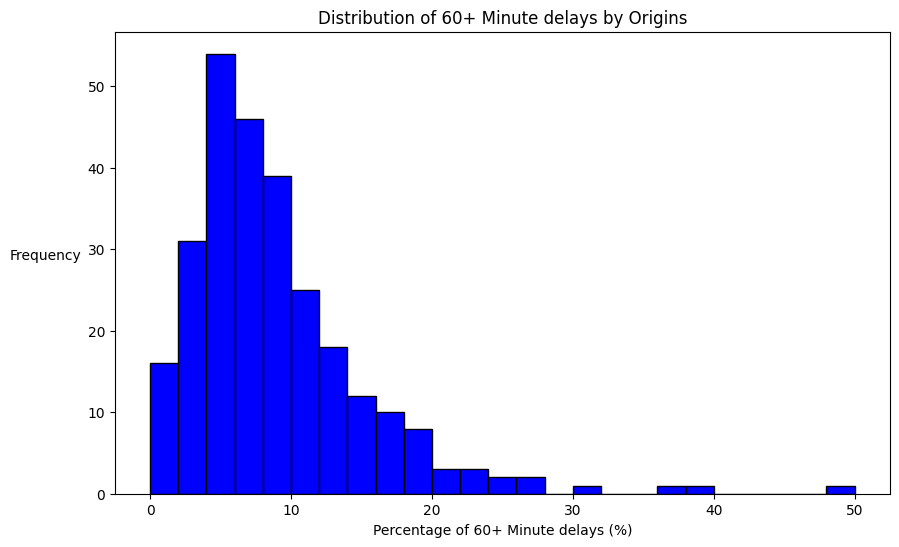

In [29]:
plt.figure(figsize=(10, 6))
plt.hist(pct_delay_by_origin.values, bins=25, color='blue', edgecolor="black")
plt.title("Distribution of 60+ Minute delays by Origins")
plt.xlabel("Percentage of 60+ Minute delays (%)")
plt.ylabel("Frequency", rotation=0, labelpad=30)
plt.show()

We observed Positively skewed distribution.

# **Fitting XGBoost classifier model**

In [30]:
xgb_model=xgb.XGBClassifier(random_state=42, eval_metrics="logloss")
xgb_model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None,
              eval_metrics='logloss', feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

Training the model

In [31]:
xgb_model.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [01:15:04] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrics" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None,
              eval_metrics='logloss', feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

Prediction using the test set.

In [32]:
y_pred=xgb_model.predict(X_test)

# **Evaluating the performance of XGBoost model**

In [33]:
print(f"Accuracy of the model is {accuracy_score(y_test, y_pred):.4f}")

Accuracy of the model is 0.9253


In [34]:
cm=confusion_matrix(y_test, y_pred)
cm

array([[134415,     81],
       [ 10781,     89]])

In [35]:
print(f"Precision of the model is {precision_score(y_test, y_pred):.4f}")
print(f"Recall of the model is {recall_score(y_test, y_pred):.4f}")
print(f"F1-Score of the model is {f1_score(y_test, y_pred):.4f}")

Precision of the model is 0.5235
Recall of the model is 0.0082
F1-Score of the model is 0.0161


Thus, the model's performance to correctly predict the delayed flights is very low.